In [14]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# 屏蔽warning信息
warnings.filterwarnings("ignore")

In [15]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
# 检查数据集大小
print(train_data.shape,test_data.shape)

(1460, 81) (1459, 80)


In [16]:
# 将所有特征进行连接，便于数据处理
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [17]:
#将所有非数值类型转化为独热代码
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

In [18]:
# 定义函数将df中的NaN替换成该列的均值
def fill_nan_with_mean(dataframe):
        for column in dataframe.columns:
            dataframe[column].fillna(dataframe[column].mean(),inplace=True)

In [19]:
n_train = train_data.shape[0]
# 使用np.vecyorize()定义一个能作用与数组的函数
object_to_float = np.vectorize(lambda x: float(x)) 
all_features = pd.DataFrame(object_to_float(all_features))
fill_nan_with_mean(all_features)

# debug:检查经处理的数据集中是否仍然含有NaN
has_nan = all_features.isnull().any().any()
if has_nan:
    print("all_features中含有NaN值")
else:
    print("all_features中没有NaN值")

# 通过pd.DataFrame.values()函数，分别提取all_features的训练集和测试集作为数组类型，并转化为tensor类型
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float64)

input_channel = train_features.shape[1]

# debug:
# print(train_features.shape,train_labels.shape)
# print(train_features[1459],train_labels[1459])

all_features中没有NaN值


In [20]:
def get_net():
    net = nn.Sequential(nn.Linear(input_channel, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(), 
                        nn.Linear(32,1)
                        )
    return net

In [21]:
def get_k_fold_data(k,i,X,y):
    assert k > 1
    dataset = torch.utils.data.TensorDataset(X,y)
    KFold(n_splits=k,shuffle=True,random_state=5)
    j = 0
    for train_index,val_index in KFold(n_splits=k,shuffle=True,random_state=5).split(dataset):
        
        # debug：
        # print('i={} j={}'.format(i,j))
        
        if i == j:
            t_features,t_labels = X[train_index],y[train_index]
            v_features,v_labels = X[val_index],y[val_index]
            break
        j += 1
    return t_features, t_labels, v_features, v_labels

In [22]:
def train(net, train_features, train_labels, val_features, val_labels, num_epochs, lr, weight_decay, batch_size,loss):
    train_array,val_array = [],[]
    train_dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size, shuffle = True)
    opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)
    
    net.train()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            opt.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            opt.step()
            
        # 以下部分是检验部分，该函数将检验部分和训练部分进行了集成，值得学习，因为检验部分和训练部分有许多循环是相同的
        train_array.append((loss(net(train_features),train_labels)).item())
        if val_labels is not None:
            net.eval()  
            with torch.no_grad(): 
                val_array.append((loss(net(val_features),val_labels)).item())
    train_array = np.array(train_array)
    val_array = np.array(val_array)
    
    # debug:
    # if np.isnan(train_array).any() or np.isnan(val_array).any():
    #     print('have NaN')
    # else:
    #     print('no NaN')
    
    return train_array,val_array

In [23]:
def k_fold(k,X_train, y_train, num_epochs, lr, loss, weight_decay, batch_size):
    t_l_sum = np.empty(num_epochs)
    v_l_sum = np.empty(num_epochs)
    for i in range(k):
        # 创建一个大小为epoch数量的空数组，以便存储每一折的训练损失和验证损失
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_arr, val_arr = train(net, *data, num_epochs, lr, weight_decay, batch_size, loss)
        
        # 取每一折所有训练损失和验证损失的和
        t_l_sum += train_arr
        v_l_sum += val_arr
        
        # debug:
        # print(t_l_sum)
        # print(v_l_sum)
        # print(np.isnan(t_l_sum))
        # print(np.isnan(v_l_sum))
        
        # # 检查NaN值
        # if np.isnan(t_l_sum).any() or np.isnan(v_l_sum).any():
        #     print(f"NaN values found in Fold {i + 1}")
            
        print('train_loss_mean{}: {}, val_loss_mean{}: {}'.format(i+1, np.mean(t_l_sum) / (i+1), i+1, np.mean(v_l_sum) / (i+1)))

    plt.figure()
    train_df = pd.DataFrame(t_l_sum / k,columns= ['train_loss'])
    val_df = pd.DataFrame(v_l_sum / k,columns= ['val_loss'])
    # fill_nan_with_mean(train_df)
    # fill_nan_with_mean(val_df)
    df = pd.concat([train_df, val_df], axis=1)
    sns.lineplot(data = df)
    plt.show()
    
    plt.figure()
    gap_loss = v_l_sum - t_l_sum
    gap_l_df = pd.DataFrame(gap_loss, columns= ['gap_loss'])
    sns.lineplot(data = gap_l_df)
    plt.show()
    
    # debug:
    # print(df)
    # print(len(train_arr),len(val_arr))

train_loss_mean1: 59203.50400189673, val_loss_mean1: 57393.35781329166
train_loss_mean2: 44319.66758154318, val_loss_mean2: 43310.23423626549
train_loss_mean3: 39138.52912820798, val_loss_mean3: 39818.25102280861
train_loss_mean4: 36618.15896809679, val_loss_mean4: 37785.945272344725
train_loss_mean5: 35201.023879161934, val_loss_mean5: 36310.65120516381


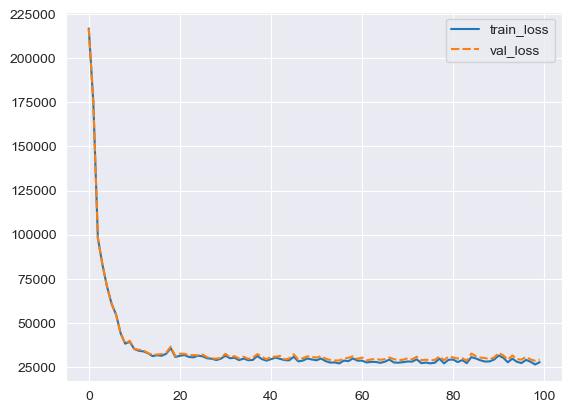

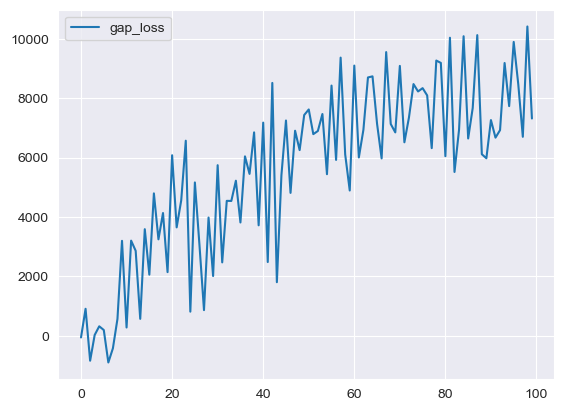

In [24]:
k = 5
num_epochs = 100
lr = 0.066
loss = nn.L1Loss()
weight_decay = 0.0033
batch_size = 128
net = get_net()
k_fold(k, train_features, train_labels, num_epochs, lr, loss, weight_decay, batch_size)
# torch.save(net.state_dict(), 'model_params.pth')

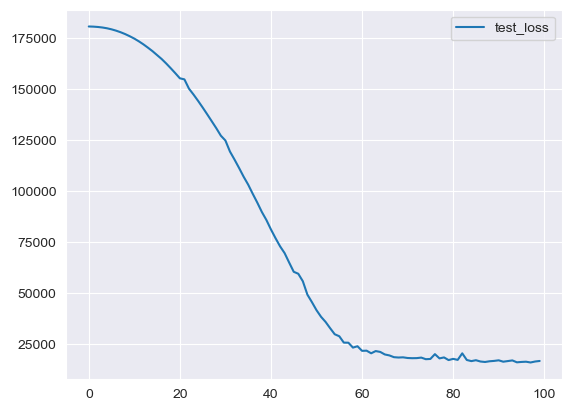

In [25]:
train_arr, _ = train(net, train_features, train_labels, None, None,num_epochs, lr, weight_decay, batch_size,loss)
sns.lineplot(data=pd.DataFrame(train_arr, columns=['test_loss']))
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)

In [26]:
# state_dict = torch.load('model_params.pth')  
# net.load_state_dict(state_dict) 
# with torch.no_grad():
#     y_hat = net(test_features)
#     print(y_hat)
# test_labels_dict = {'SalePrice': y_hat.numpy().flatten()}
# test_labels = pd.DataFrame(test_labels_dict)
# submission = pd.concat([test_data['Id'], test_labels], axis=1)
# submission.to_csv('submission.csv', index=False)